# Bruker Data Grepping and Alignment Notebook
### Jeremy Delahanty June 2021

Intended to grep different files/projects/datasets from user input and retain them for use in analysis/display later. The lack of unified filenaming structures between projects will break the code... A convetion of XXX### for animal names has been established for Austin's projects

In [1]:
# Import packages
from pathlib import Path
import pathlib
import glob
import re
import json
import numpy as np
import matplotlib.pyplot as plt
import warnings
import tables
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd


In [2]:
lab_basepath = "Y:/"
# project_dict = {"specialk": ["learned_helplessness", "chronic_mild_stress"]}

In [3]:
def grep_teams(team_selection=[], lab_basepath="Y:/"):
    """
    Grabs team list from server based on user's input.
    
    User can define which teams they want to use for their analyses and
    the function will glob the paths for their selection.
    
    Parameters
    ----------
    arg1: list
        List of strings for teams of interest
        Default is empty list
    arg2: string
        Basepath for server location on machine
        Default is Y:/ for mapped Windows drive
    
    
    Returns
    -------
    1. list
        List of team path grabbed from server successfully
    2. list
        List of teams not found
    """

    # Take basepath and glob all available files and directories
    team_glob = Path(lab_basepath).glob("{}".format("*"))
    
    # Check if no team was specifically asked for, tell user we're gathering all teams
    if team_selection == []:

        print("Gathering all teams...")

        # List comprehension for returning all directories in Tye Lab server
        team_list = [team for team in team_glob if team.is_dir()]

    else:
        
        # List comprehension for returning only directories user wants in the Tye Lab server 
        team_list = [team for team in team_glob if team.name in team_selection and team.is_dir()]
    
    # Create temporary list for checking if selected teams exist
    tmp = []

    # For the teams that were globbed successfully, append the team to the temp list
    for globbed_team in team_list:
        tmp.append(globbed_team.name)
    
    # Compare team selection with returned teams using sets, convert to list
    missing_teams = list(set(team_selection) - set(tmp))
    
    # If the missing_teams list is empty, the program found all requested teams
    if missing_teams == []:
        print("Found All Selected Teams")
    
    # Else, some teams weren't found. Tell the user which teams weren't found.
    else:
        print("Failed to find team(s):", missing_teams)
   
    # Show user which teams were returned
    print("Teams Returned:")
    for team in team_list:
        print("{} ".format(team.name))
    
    # Return the list of projects gathered
    return team_list, missing_teams

team_list, missing_teams = grep_teams(["specialk"])

Found All Selected Teams
Teams Returned:
specialk 


In [4]:
def choose_projects(team_list, project_selection={}):
    """
    Generates project paths list based on user's selection.
    
    User can define which project they want to use for their analyses and
    this function generates the paths for their selection.
    
    Parameters
    ----------
    arg1: list
        List of strings for teams of interest from grep_teams()
    arg2: dict
        Dictionary of values that will be used to create specific
        paths for selected teams and their projects
    
    Returns
    -------
    1. list
        List of team/project Paths to grep in next steps
    """

    # Make dictionary using the teams in team_list as keys
    project_dict = {team: [] for team in team_list}

    # For each time in the team_list, append the Path name's project's values
    for team in team_list:
        project_dict[team].append(project_selection[team.name])
    
    # Make empty project list
    project_dir_list = []

    for team in project_dict.keys():
        for project in range(len(project_dict[team][0])):
            project_dir_list.append(team / project_dict[team][0][project])
    
    print("Returned Directories: ")

    for directory in project_dir_list:
        print(directory)
    
    return project_dir_list
    
project_list = choose_projects(team_list, project_selection={"specialk": ["learned_helplessness"]})

Returned Directories: 
Y:\specialk\learned_helplessness


In [5]:
def choose_animals(project_list, animal_group="all"):
    """
    Generates animal paths list based on user's selection.
    
    User can define which cohort of animals they want to use 
    for their analyses. This function generates the paths for 
    their selection that meet specified conditions.
    
    Parameters
    ----------
    arg1: list
        List of strings for projects of interest from choose_projects()
    arg2: str
        String of value for which animal paths to gather.
        Default value is all.
    
    Returns
    -------
    1. list
        List of team/project/animal Paths to grep in next steps
    """
    
    # Create empty animal list for path generation
    animal_list = []
    
    # If the animal group is left as default/specified as all, grab all animals
    if animal_group == "all":
        print("Grabbing all animals...")
        
        # For each project directory in the project list
        for project_dir in project_list:
            
            # For each animal globbed in the project directory
            for animal in project_dir.glob("*"):
                
                # Append the animal's path to the animal_list
                print(project_dir.name, animal.name)
                animal_list.append(animal)
    
    # Else, only select animals from the specified group
    else:
        print("Grabbing only {} animals...".format(animal_group))

        # Format the animal group with the user's input
        animal_group = "[A-Z]{2}" + animal_group + "\d{3}"
        
        # For each project_directory in project_list
        for project_dir in project_list:

            # For each animal globbed in project directory
            for animal in project_dir.glob("*"):
                
                # Use regex to grab only the requested animal
                r = re.search(animal_group, string=animal.name)
                
                # If the search returns None, the animal didn't match the request
                # Skip over it with pass.
                if r is None:
                    pass
                
                # If something is returned, take the match object's value and append
                # the animal to the project directory.
                else:
                    print(project_dir.name, r.group(0))
                    animal_list.append(project_dir / r.group(0))
    
    # Finally, return the list of animals
    return animal_list

animal_list = choose_animals(project_list, animal_group="E")

Grabbing only E animals...
learned_helplessness LHE011
learned_helplessness LHE012
learned_helplessness LHE013
learned_helplessness LHE014
learned_helplessness LHE015
learned_helplessness LHE016


In [6]:
def choose_data(animal_list, data_group=[], verbose=True):
    """
    Generates animal's data paths list based on user's selection.
    
    User can define which dataset to use for the animals they 
    want to use for their analyses. This function generates the
    paths for their selection that meet specified conditions.
    
    Parameters
    ----------
    arg1: list
        List of paths for animals of interest from choose_animals()
    arg2: list
        List of strings for which datasets to gather.
        Default value is all.
    arg3: bool
        Boolean argument for verbose output of paths found or
        not found by the function. Default is True.
    
    Returns
    -------
    1. list
        List of team/project/animal/dataset Paths to grep in
        next steps
    """
    
    # Create empty data list for path generation
    data_dir_list = []
    
    # If data_group is left as default or specified as empty,
    # grab all folders
    if data_group == []:
        print("Grabbing all data folders...")
        
        # For each animal in the animal list
        for animal in animal_list:
            
            # For the data_dir in the globbed animal_path
            for data_dir in animal.glob("*"):
                
                # Append the data_dir to the data_list
                print("Grabbing", animal.name, data_dir.name)
                data_list.append(data)
    
    #TODO: Make verbose into its own function
    elif len(data_group) > 0 and verbose is True:
        print("Grabbing...")
        for data_type in data_group:
            print(data_type, "data")

        print("\nFrom Projects(s)...")
        project_list = list(set([project.parent.name for project in animal_list]))
        for project in project_list:
            print(project)
            
        print("\nIn Team(s)...")
        team_list = list(set([team.parent.parent.name for team in animal_list]))
        for team in team_list:
            print(team)
        print("\nFor Animals...")
        for animal in animal_list:
            print(animal.name)
        
        print("\nChecking for directories...")
        for animal in animal_list:
            for data_type in data_group:
                if (animal / data_type).is_dir():
                    print("Found", animal.name, data_type)
                    data_dir_list.append(animal / data_type)
                else:
                    print("Not Found!", animal.name, data_type)
    else:
       
        #TODO: Write a function for checking
        print("Grabbing specified directories...", "\n", data_group)
        
        for animal in animal_list:
            for data_type in data_group:
                if (animal / data_type).is_dir():
                    data_dir_list.append(animal / data_type)
                else:
                    print(animal.name, data_type, "Not Found!")
    
    # Tell user which directories were returned
    print("\nReturning Directories:")
    for data_dir in data_dir_list:
        print(data_dir)

    return data_dir_list
                

data_dir_list = choose_data(animal_list, data_group=["twop"], verbose=False)

Grabbing specified directories... 
 ['twop']

Returning Directories:
Y:\specialk\learned_helplessness\LHE011\twop
Y:\specialk\learned_helplessness\LHE012\twop
Y:\specialk\learned_helplessness\LHE013\twop
Y:\specialk\learned_helplessness\LHE014\twop
Y:\specialk\learned_helplessness\LHE015\twop
Y:\specialk\learned_helplessness\LHE016\twop


In [7]:
def grep_twop_raw_behavior_data(data_directory, convert_missing_data=False, verbose=True):
    """
    Checks whether raw 2P behavior data has been converted to .csv for all available days.
    
    Parameters
    ----------
    arg1: Path
        Parent directory of raw behavior data file
        
    arg2: bool
        Whether to invoke raw data file conversion through Bruker's raw converter
        Default False; no containerized ripper is in place (7/29/21)...
        
    arg3: bool
        Whether to print checking process for the user.
        Default True
        
    Returns
    -------
    1. list
        Existing raw behavior data file paths 
    """
    
    checked_behavior_file_list = []
    
    missing_behavior_dir_list = []
    
    raw_behavior_dir_search = data_directory.glob("*/*")
    
    raw_behavior_dir_dict = {result.parent : [file for file in result.glob("*.csv")] for result in raw_behavior_dir_search if result.is_dir()}
    
    if verbose is True:
        for key in raw_behavior_dir_dict:
            print("\nChecking if", key.parents[1].name, key.parents[0].name, key.name, "raw behavior is converted...")
            if len(raw_behavior_dir_dict[key]) == 0:
                print("\nWARNING!!!", key.parents[1].name, key.parents[0].name, key.name, "raw behavior not converted!")
                missing_behavior_dir_list.append(raw_behavior_dir_dict[key])
            else:
                print(key.parents[1].name, key.parents[0].name, key.name,  "raw behavior converted!")
                checked_behavior_file_list.append(raw_behavior_dir_dict[key][0])
                
        print("\nReturning checked files:")
        for file in checked_behavior_file_list:
            print(file)
            
        
    else:
        # TODO: This should be a warning/exception that is logged and/or saved somewhere maybe...
        for key in raw_behavior_dir_dict:
            if len(raw_behavior_dir_dict[key]) == 0:
                print("WARNING!!!", key.parents[1].name, key.parents[0].name, key.name, "raw data not converted!")
            else:
                checked_behavior_file_list.append(raw_behavior_dir_dict[key][0])

    return checked_behavior_file_list

checked_behavior_file_list = grep_twop_raw_behavior_data(data_dir_list[0])


Checking if LHE011 twop 20210602 raw behavior is converted...

WARNING!!! LHE011 twop 20210602 raw behavior not converted!

Checking if LHE011 twop 20210603 raw behavior is converted...
LHE011 twop 20210603 raw behavior converted!

Checking if LHE011 twop 20210604 raw behavior is converted...
LHE011 twop 20210604 raw behavior converted!

Checking if LHE011 twop 20210605 raw behavior is converted...
LHE011 twop 20210605 raw behavior converted!

Checking if LHE011 twop 20210607 raw behavior is converted...
LHE011 twop 20210607 raw behavior converted!

Checking if LHE011 twop 20210608 raw behavior is converted...
LHE011 twop 20210608 raw behavior converted!

Checking if LHE011 twop 20210611 raw behavior is converted...
LHE011 twop 20210611 raw behavior converted!

Checking if LHE011 twop 20210612 raw behavior is converted...
LHE011 twop 20210612 raw behavior converted!

Returning checked files:
Y:\specialk\learned_helplessness\LHE011\twop\20210603\20210603_LHE011_plane0_raw_behavior-042\

In [8]:
def grep_twop_behavior_config(checked_behavior_file_list):
    """
    Generates animal's configuration paths list based on user's selection
    
    Parameters
    ----------
    arg1: list
        List of paths for animals of interest from choose_data()
    
    Returns
    -------
    1. list
        List of 2P behavior configuration Paths
    """
    
    twop_config_list = []
    
    for directory in checked_behavior_file_list:
        parent_dir = directory.parents[1]
        search = parent_dir.glob("*config.json")
        for result in search:
            twop_config_list.append(result)
            
    return twop_config_list
            
twop_config_list = grep_twop_behavior_config(checked_behavior_file_list)

In [9]:
%%time
def clean_2p_behavior(twop_raw_behavior_file, raw_keys=["Lick", "Airpuff", "Liquid", "Speaker"], df_keys=["on", "off"]):
    """
    Takes in raw 2P behavior file produced by Bruker and generates timestamps.
    
    Parameters
    ----------
    arg1: Path
        Path to raw behavior data
    arg2: list
        List of raw data keys to clean
        Default is Lick, Airpuff, Liquid, and Speaker data
    arg3: list
        List of keys to create for dataframe
        Default is onset AND offset of each event
    
    Returns
    -------
    1. dict
        Dictionary containing timestamps for each event
    """

    # Create list of requested keys by concatenating each value in the raw and df keys arguments
    requested_keys = []
    
    for raw_key in raw_keys:
        for df_key in df_keys:
            requested_keys.append(raw_key + "_" + df_key)
    
    
    # Do the cleaning for the supplied raw data file
    # Tell the user which file is being processed
    print("Cleaning:", twop_raw_behavior_file.name)

    # Adapting code by Kyle Fischer, June 2021 thru line 44
    # Read the raw .csv from Bruker's Voltage Recording
    raw_behavior_df = pd.read_csv(twop_raw_behavior_file, index_col="Time(ms)").rename(columns=lambda col:col.strip())

    # Any value below 3V is certainly noise.  Set them to zero by filtering the raw dataframe
    raw_behavior_df = raw_behavior_df > 3

    # Convert all values to int for pandas.DataFrame.diff() to yield negative values for stop times
    # and then perform the .diff() function and finally use .fillna() to eliminate NaN values
    raw_behavior_df = raw_behavior_df.astype(int).diff().fillna(0)

    # Create empty dictionary for cleaned timestamps
    cleaned_behavior_dict = {}

    # Query the raw datafile for each condition.  1 represents "On" signal while -1 represents "Off"
    for key in requested_keys:
        if "on" in key:
            cleaned_behavior_dict[key] = raw_behavior_df.query(key.split("_")[0] + " == 1").index.tolist()
        else:
            cleaned_behavior_dict[key] = raw_behavior_df.query(key.split("_")[0] + " == -1").index.tolist()

    return cleaned_behavior_dict

cleaned_behavior_dict = clean_2p_behavior(checked_behavior_file_list[0])

Cleaning: 20210603_LHE011_plane0-042_Cycle00001_VoltageRecording_001.csv
Wall time: 2.18 s


In [10]:
%%time
def get_2p_trialtypes(twop_config_file):
    """
    Takes in twop configuration file and gives trial types
    
    Parameters
    ----------
    arg1: Path
        Path two behavior configuration file
    
    Returns
    -------
    1. list
        Gives list of trial types
    """
    
    # Open the json file using json package
    with open(twop_config_file, "r") as inFile:

        # Read the config file
        config = inFile.read()

        # Decode the file with json.loads()
        config_contents = json.loads(config)

        # Gather the trial types from the configuration
        config_trial_types = config_contents["trialArray"]
        
    return config_trial_types

    
config_trial_types = get_2p_trialtypes(twop_config_list[0])

Wall time: 27.9 ms


In [11]:
def build_base_stimulus_df(config_trial_types):
    """
    Creates trial DataFrame from configuration trial types
    
    Parameters
    ----------
    arg1: list
        List of trial types obtained from get_2p_trialtypes()
    
    Returns
    -------
    1. Pandas DataFrame
        Returns base dataframe of trial types
    """
    
    base_behavior_df = pd.DataFrame()
    
    liquid_counter = 0
    airpuff_counter = 0
    
    for (index, trial) in enumerate(config_trial_types):
        if trial == 1:
            liquid_counter += 1
            trial_name = "Trial_" + str(index + 1)
            trial_type = "Sucrose_" + str(liquid_counter)
            series = pd.Series(trial_type, dtype=str, name=trial_name)
            base_behavior_df = base_behavior_df.append(series)
        else:
            airpuff_counter += 1
            trial_name = "Trial_" + str(index + 1)
            trial_type = "Airpuff_" + str(airpuff_counter)
            series = pd.Series(trial_type, dtype=str, name=trial_name)
            base_behavior_df = base_behavior_df.append(series)

    base_behavior_df.reset_index(inplace=True)
    base_behavior_df.columns = ["trial", "trial_type"]

    
    return base_behavior_df

base_df = build_base_stimulus_df(config_trial_types)

In [12]:
def build_cleaned_stimulus_df(clean_behavior_dict):
    """
    Creates cleaned stimulus dataframe of timestamps from cleaned behavior dictionary
    
    Parameters
    ----------
    1. dict
        Cleaned behavior dictionary from clean_2p_behavior()
    
    Returns
    -------
    1. Pandas DataFrame
        Dataframe of cleaned behavior timestamps per trial
    """
    
    if len(cleaned_behavior_dict["Airpuff_on"]) == 0:
        cleaned_stimulus_df_keys = [key for key in cleaned_behavior_dict if "Lick" not in key and "Airpuff" not in key]
    else:
        cleaned_stimulus_df_keys = [key for key in cleaned_behavior_dict if "Lick" not in key]
    
    cleaned_stimulus_df = pd.DataFrame(columns=cleaned_stimulus_df_keys)
    
    for key in cleaned_stimulus_df_keys:
        cleaned_stimulus_df[key] = pd.Series(cleaned_behavior_dict[key]).divide(1000)
    
    return cleaned_stimulus_df
        

clean_df = build_cleaned_stimulus_df(cleaned_behavior_dict)

In [13]:
def build_behavior_stimulus_df(base_df, clean_df):
    """
    Joins cleaned_stimulus_df and base_behavior_df into one DataFrame
    
    Parameters
    ----------
    1. Pandas DataFrame
        Base behavior dataframe (trial types)
    2. Pandas DataFrame
        Cleaned stimulus dataframe (timestamps)
    
    Results
    -------
    1. Pandas DataFrame
        Dataframe from united base and stimulus inputs
    """
    
    merged_behavior_df = base_df.join(clean_df, how="outer")
    
    return merged_behavior_df
    
merged_behavior_df = build_behavior_stimulus_df(base_df, clean_df)

In [14]:
def write_merged_behavior_hdf(checked_behavior_file, merged_behavior_df, config_trialtypes, lick_timestamps):
    """
    Writes hdf5 file of cleaned data for a given session to disk
    
    Parameters
    ----------
    1. Path
        Path of checked behavior
    2. pandas.Dataframe
        Cleaned behavior dataframe of trials and stimuli
    3. list
        List of trial types from configuration file
    4. list
        List of lick timestamps from cleaned_behavior_dict
    
    Returns
    -------
    None
    """
    
    
    filename_pattern = re.compile("\d{8}_[A-Z]{3}\d{3}_plane\d{1}")
    
    re_filename_result = re.search(pattern=filename_pattern, string=checked_behavior_file.name)
    
    hdf_filename = checked_behavior_file.parents[1] / (re_filename_result.group(0) + "_merged.h5")
    
    merged_behavior_df.set_index("trial", inplace=True)
    
    trial_types = pd.Series(config_trialtypes)
    
    lick_timestamps = pd.Series(lick_timestamps)
    
    hdf_store = pd.HDFStore(hdf_filename)
    
    hdf_store.append(value=merged_behavior_df, key="stimulus_timestamps")
    
    hdf_store.append(value=trial_types, key="trial_types")
    
    hdf_store.append(value=lick_timestamps, key="lick_timestamps")
    
    tables.file._open_files.close_all()
    

write_merged_behavior_hdf(checked_behavior_file_list[0], merged_behavior_df, config_trial_types, cleaned_behavior_dict["Lick_on"])

Closing remaining open files:Y:\specialk\learned_helplessness\LHE011\twop\20210603\20210603_LHE011_plane0_merged.h5...done


In [34]:
def merge_bruker_twop_data(data_dir_list):
    
    for data_dir in data_dir_list:
        checked_behavior_file_list = grep_twop_raw_behavior_data(data_dir)
        twop_config_list = grep_twop_behavior_config(checked_behavior_file_list)
        for file, config in zip(checked_behavior_file_list, twop_config_list):
            cleaned_behavior_dict = clean_2p_behavior(file)
            config_trial_types = get_2p_trialtypes(config)
            base_df = build_base_stimulus_df(config_trial_types)
            clean_df = build_cleaned_stimulus_df(cleaned_behavior_dict)
            merged_behavior_df = build_behavior_stimulus_df(base_df, clean_df)
            write_merged_behavior_hdf(file, merged_behavior_df, config_trial_types, cleaned_behavior_dict["Lick_on"])
            
            
            
        
        
        
merge_bruker_twop_data(data_dir_list)


Checking if LHE011 twop 20210602 raw behavior is converted...

WARNING!!! LHE011 twop 20210602 raw behavior not converted!

Checking if LHE011 twop 20210603 raw behavior is converted...
LHE011 twop 20210603 raw behavior converted!

Checking if LHE011 twop 20210604 raw behavior is converted...
LHE011 twop 20210604 raw behavior converted!

Checking if LHE011 twop 20210605 raw behavior is converted...
LHE011 twop 20210605 raw behavior converted!

Checking if LHE011 twop 20210607 raw behavior is converted...
LHE011 twop 20210607 raw behavior converted!

Checking if LHE011 twop 20210608 raw behavior is converted...
LHE011 twop 20210608 raw behavior converted!

Checking if LHE011 twop 20210611 raw behavior is converted...
LHE011 twop 20210611 raw behavior converted!

Checking if LHE011 twop 20210612 raw behavior is converted...
LHE011 twop 20210612 raw behavior converted!

Returning checked files:
Y:\specialk\learned_helplessness\LHE011\twop\20210603\20210603_LHE011_plane0_raw_behavior-042\

Closing remaining open files:Y:\specialk\learned_helplessness\LHE011\twop\20210603\20210603_LHE011_plane0_merged.h5...done


Cleaning: 20210604_LHE011_plane0-048_Cycle00001_VoltageRecording_001.csv


Closing remaining open files:Y:\specialk\learned_helplessness\LHE011\twop\20210604\20210604_LHE011_plane0_merged.h5...done


Cleaning: 20210605_LHE011_plane0-056_Cycle00001_VoltageRecording_001.csv


Closing remaining open files:Y:\specialk\learned_helplessness\LHE011\twop\20210605\20210605_LHE011_plane0_merged.h5...done


Cleaning: 20210607_LHE011_plane0-070_Cycle00001_VoltageRecording_001.csv


Closing remaining open files:Y:\specialk\learned_helplessness\LHE011\twop\20210607\20210607_LHE011_plane0_merged.h5...done


Cleaning: 20210608_LHE011_plane0-071_Cycle00001_VoltageRecording_001.csv


Closing remaining open files:Y:\specialk\learned_helplessness\LHE011\twop\20210608\20210608_LHE011_plane0_merged.h5...done


Cleaning: 20210611_LHE011_plane0-081_Cycle00001_VoltageRecording_001.csv


Closing remaining open files:Y:\specialk\learned_helplessness\LHE011\twop\20210611\20210611_LHE011_plane0_merged.h5...done


Cleaning: 20210612_LHE011_plane0-084_Cycle00001_VoltageRecording_001.csv


Closing remaining open files:Y:\specialk\learned_helplessness\LHE011\twop\20210612\20210612_LHE011_plane0_merged.h5...done



Checking if LHE012 twop 20210602 raw behavior is converted...

WARNING!!! LHE012 twop 20210602 raw behavior not converted!

Checking if LHE012 twop 20210603 raw behavior is converted...
LHE012 twop 20210603 raw behavior converted!

Checking if LHE012 twop 20210604 raw behavior is converted...
LHE012 twop 20210604 raw behavior converted!

Checking if LHE012 twop 20210605 raw behavior is converted...
LHE012 twop 20210605 raw behavior converted!

Checking if LHE012 twop 20210606 raw behavior is converted...
LHE012 twop 20210606 raw behavior converted!

Checking if LHE012 twop 20210607 raw behavior is converted...
LHE012 twop 20210607 raw behavior converted!

Checking if LHE012 twop 20210610 raw behavior is converted...
LHE012 twop 20210610 raw behavior converted!

Checking if LHE012 twop 20210611 raw behavior is converted...
LHE012 twop 20210611 raw behavior converted!

Returning checked files:
Y:\specialk\learned_helplessness\LHE012\twop\20210603\20210603_LHE012_plane0_raw_behavior-043\

Closing remaining open files:Y:\specialk\learned_helplessness\LHE012\twop\20210603\20210603_LHE012_plane0_merged.h5...done


Cleaning: 20210604_LHE012_plane0-049_Cycle00001_VoltageRecording_001.csv


Closing remaining open files:Y:\specialk\learned_helplessness\LHE012\twop\20210604\20210604_LHE012_plane0_merged.h5...done


Cleaning: 20210605_LHE012_plane0-057_Cycle00001_VoltageRecording_001.csv


Closing remaining open files:Y:\specialk\learned_helplessness\LHE012\twop\20210605\20210605_LHE012_plane0_merged.h5...done


Cleaning: 20210606_LHE012_plane0-063_Cycle00001_VoltageRecording_001.csv


Closing remaining open files:Y:\specialk\learned_helplessness\LHE012\twop\20210606\20210606_LHE012_plane0_merged.h5...done


Cleaning: 20210607_LHE012_plane0-069_Cycle00001_VoltageRecording_001.csv


Closing remaining open files:Y:\specialk\learned_helplessness\LHE012\twop\20210607\20210607_LHE012_plane0_merged.h5...done


Cleaning: 20210610_LHE012_plane0-078_Cycle00001_VoltageRecording_001.csv


Closing remaining open files:Y:\specialk\learned_helplessness\LHE012\twop\20210610\20210610_LHE012_plane0_merged.h5...done


Cleaning: 20210611_LHE012_plane0-082_Cycle00001_VoltageRecording_001.csv


Closing remaining open files:Y:\specialk\learned_helplessness\LHE012\twop\20210611\20210611_LHE012_plane0_merged.h5...done



Checking if LHE013 twop 20210602 raw behavior is converted...

WARNING!!! LHE013 twop 20210602 raw behavior not converted!

Checking if LHE013 twop 20210603 raw behavior is converted...
LHE013 twop 20210603 raw behavior converted!

Checking if LHE013 twop 20210604 raw behavior is converted...
LHE013 twop 20210604 raw behavior converted!

Checking if LHE013 twop 20210605 raw behavior is converted...
LHE013 twop 20210605 raw behavior converted!

Checking if LHE013 twop 20210606 raw behavior is converted...
LHE013 twop 20210606 raw behavior converted!

Checking if LHE013 twop 20210609 raw behavior is converted...

WARNING!!! LHE013 twop 20210609 raw behavior not converted!

Checking if LHE013 twop 20210610 raw behavior is converted...
LHE013 twop 20210610 raw behavior converted!

Returning checked files:
Y:\specialk\learned_helplessness\LHE013\twop\20210603\20210603_LHE013_plane0_raw_behavior-044\20210603_LHE013_plane0-044_Cycle00001_VoltageRecording_001.csv
Y:\specialk\learned_helplessn

Closing remaining open files:Y:\specialk\learned_helplessness\LHE013\twop\20210603\20210603_LHE013_plane0_merged.h5...done


Cleaning: 20210604_LHE013_plane0-051_Cycle00001_VoltageRecording_001.csv


Closing remaining open files:Y:\specialk\learned_helplessness\LHE013\twop\20210604\20210604_LHE013_plane0_merged.h5...done


Cleaning: 20210605_LHE013_plane0-058_Cycle00001_VoltageRecording_001.csv


Closing remaining open files:Y:\specialk\learned_helplessness\LHE013\twop\20210605\20210605_LHE013_plane0_merged.h5...done


Cleaning: 20210606_LHE013_plane0-064_Cycle00001_VoltageRecording_001.csv


Closing remaining open files:Y:\specialk\learned_helplessness\LHE013\twop\20210606\20210606_LHE013_plane0_merged.h5...done


Cleaning: 20210610_LHE013_plane0-076_Cycle00001_VoltageRecording_001.csv


Closing remaining open files:Y:\specialk\learned_helplessness\LHE013\twop\20210610\20210610_LHE013_plane0_merged.h5...done



Checking if LHE014 twop 20210602 raw behavior is converted...

WARNING!!! LHE014 twop 20210602 raw behavior not converted!

Checking if LHE014 twop 20210603 raw behavior is converted...
LHE014 twop 20210603 raw behavior converted!

Checking if LHE014 twop 20210604 raw behavior is converted...
LHE014 twop 20210604 raw behavior converted!

Checking if LHE014 twop 20210605 raw behavior is converted...
LHE014 twop 20210605 raw behavior converted!

Checking if LHE014 twop 20210606 raw behavior is converted...
LHE014 twop 20210606 raw behavior converted!

Checking if LHE014 twop 20210609 raw behavior is converted...
LHE014 twop 20210609 raw behavior converted!

Checking if LHE014 twop 20210610 raw behavior is converted...
LHE014 twop 20210610 raw behavior converted!

Returning checked files:
Y:\specialk\learned_helplessness\LHE014\twop\20210603\20210603_LHE014_plane0_raw_behavior-045\20210603_LHE014_plane0-045_Cycle00001_VoltageRecording_001.csv
Y:\specialk\learned_helplessness\LHE014\twop\

Closing remaining open files:Y:\specialk\learned_helplessness\LHE014\twop\20210603\20210603_LHE014_plane0_merged.h5...done


Cleaning: 20210604_LHE014_plane0-052_Cycle00001_VoltageRecording_001.csv


Closing remaining open files:Y:\specialk\learned_helplessness\LHE014\twop\20210604\20210604_LHE014_plane0_merged.h5...done


Cleaning: 20210605_LHE014_plane0-059_Cycle00001_VoltageRecording_001.csv


Closing remaining open files:Y:\specialk\learned_helplessness\LHE014\twop\20210605\20210605_LHE014_plane0_merged.h5...done


Cleaning: 20210606_LHE014_plane0-065_Cycle00001_VoltageRecording_001.csv


Closing remaining open files:Y:\specialk\learned_helplessness\LHE014\twop\20210606\20210606_LHE014_plane0_merged.h5...done


Cleaning: 20210609_LHE014_plane0-073_Cycle00001_VoltageRecording_001.csv


Closing remaining open files:Y:\specialk\learned_helplessness\LHE014\twop\20210609\20210609_LHE014_plane0_merged.h5...done


Cleaning: 20210610_LHE014_plane0-077_Cycle00001_VoltageRecording_001.csv


Closing remaining open files:Y:\specialk\learned_helplessness\LHE014\twop\20210610\20210610_LHE014_plane0_merged.h5...done



Checking if LHE015 twop 20210602 raw behavior is converted...

WARNING!!! LHE015 twop 20210602 raw behavior not converted!

Checking if LHE015 twop 20210603 raw behavior is converted...
LHE015 twop 20210603 raw behavior converted!

Checking if LHE015 twop 20210604 raw behavior is converted...
LHE015 twop 20210604 raw behavior converted!

Checking if LHE015 twop 20210605 raw behavior is converted...
LHE015 twop 20210605 raw behavior converted!

Checking if LHE015 twop 20210606 raw behavior is converted...
LHE015 twop 20210606 raw behavior converted!

Checking if LHE015 twop 20210609 raw behavior is converted...
LHE015 twop 20210609 raw behavior converted!

Checking if LHE015 twop 20210610 raw behavior is converted...
LHE015 twop 20210610 raw behavior converted!

Checking if LHE015 twop 20210611 raw behavior is converted...
LHE015 twop 20210611 raw behavior converted!

Returning checked files:
Y:\specialk\learned_helplessness\LHE015\twop\20210603\20210603_LHE015_plane0_raw_behavior-046\

Closing remaining open files:Y:\specialk\learned_helplessness\LHE015\twop\20210603\20210603_LHE015_plane0_merged.h5...done


Cleaning: 20210604_LHE015_plane0-053_Cycle00001_VoltageRecording_001.csv


Closing remaining open files:Y:\specialk\learned_helplessness\LHE015\twop\20210604\20210604_LHE015_plane0_merged.h5...done


Cleaning: 20210605_LHE015_plane0-060_Cycle00001_VoltageRecording_001.csv


Closing remaining open files:Y:\specialk\learned_helplessness\LHE015\twop\20210605\20210605_LHE015_plane0_merged.h5...done


Cleaning: 20210606_LHE015_plane0-066_Cycle00001_VoltageRecording_001.csv


Closing remaining open files:Y:\specialk\learned_helplessness\LHE015\twop\20210606\20210606_LHE015_plane0_merged.h5...done


Cleaning: 20210609_LHE015_plane0-074_Cycle00001_VoltageRecording_001.csv


Closing remaining open files:Y:\specialk\learned_helplessness\LHE015\twop\20210609\20210609_LHE015_plane0_merged.h5...done


Cleaning: 20210610_LHE015_plane0-079_Cycle00001_VoltageRecording_001.csv


Closing remaining open files:Y:\specialk\learned_helplessness\LHE015\twop\20210610\20210610_LHE015_plane0_merged.h5...done



Checking if LHE016 twop 20210602 raw behavior is converted...

WARNING!!! LHE016 twop 20210602 raw behavior not converted!

Checking if LHE016 twop 20210603 raw behavior is converted...
LHE016 twop 20210603 raw behavior converted!

Checking if LHE016 twop 20210604 raw behavior is converted...
LHE016 twop 20210604 raw behavior converted!

Checking if LHE016 twop 20210605 raw behavior is converted...
LHE016 twop 20210605 raw behavior converted!

Checking if LHE016 twop 20210606 raw behavior is converted...
LHE016 twop 20210606 raw behavior converted!

Checking if LHE016 twop 20210609 raw behavior is converted...
LHE016 twop 20210609 raw behavior converted!

Checking if LHE016 twop 20210610 raw behavior is converted...
LHE016 twop 20210610 raw behavior converted!

Returning checked files:
Y:\specialk\learned_helplessness\LHE016\twop\20210603\20210603_LHE016_plane0_raw_behavior-047\20210603_LHE016_plane0-047_Cycle00001_VoltageRecording_001.csv
Y:\specialk\learned_helplessness\LHE016\twop\

Closing remaining open files:Y:\specialk\learned_helplessness\LHE016\twop\20210603\20210603_LHE016_plane0_merged.h5...done


Cleaning: 20210604_LHE016_plane0-055_Cycle00001_VoltageRecording_001.csv


Closing remaining open files:Y:\specialk\learned_helplessness\LHE016\twop\20210604\20210604_LHE016_plane0_merged.h5...done


Cleaning: 20210605_LHE016_plane0-061_Cycle00001_VoltageRecording_001.csv


Closing remaining open files:Y:\specialk\learned_helplessness\LHE016\twop\20210605\20210605_LHE016_plane0_merged.h5...done


Cleaning: 20210606_LHE016_plane0-067_Cycle00001_VoltageRecording_001.csv


Closing remaining open files:Y:\specialk\learned_helplessness\LHE016\twop\20210606\20210606_LHE016_plane0_merged.h5...done


Cleaning: 20210609_LHE016_plane0-075_Cycle00001_VoltageRecording_001.csv


Closing remaining open files:Y:\specialk\learned_helplessness\LHE016\twop\20210609\20210609_LHE016_plane0_merged.h5...done


Cleaning: 20210610_LHE016_plane0-080_Cycle00001_VoltageRecording_001.csv


Closing remaining open files:Y:\specialk\learned_helplessness\LHE016\twop\20210610\20210610_LHE016_plane0_merged.h5...done


In [36]:
pd.read_hdf("Y:/specialk/learned_helplessness/LHE011/twop/20210603/20210603_LHE011_plane0_merged.h5", key="lick_timestamps")

0     392132
1     421719
2     421890
3     422130
4     422309
5     422491
6     423184
7     591335
8     591479
9     591567
10    591677
11    605736
12    605900
13    610886
14    615826
15    617953
16    618105
17    618269
18    618645
19    618873
20    619079
21    619889
22    622463
23    622623
24    623106
25    624959
26    627530
27    627693
28    627891
29    689528
30    690924
dtype: int64

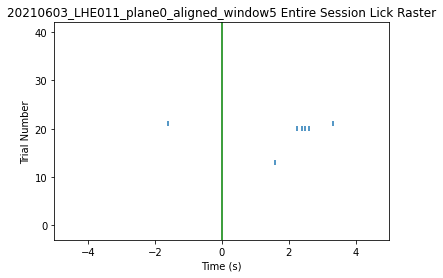

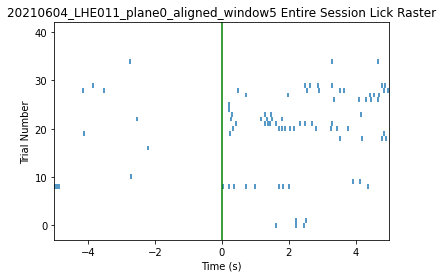

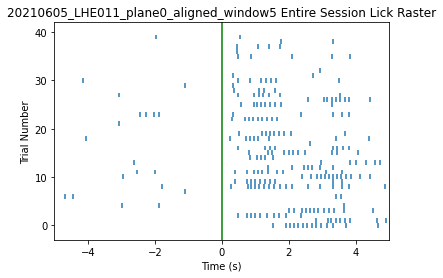

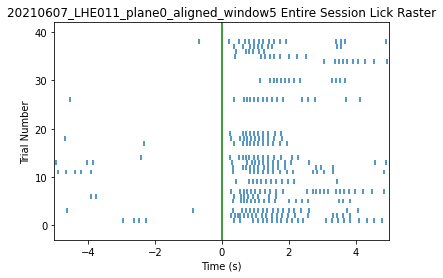

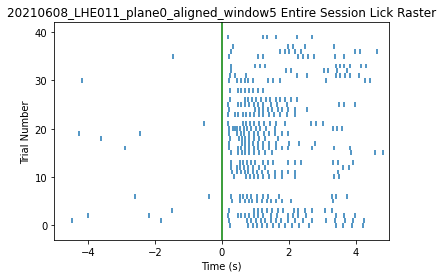

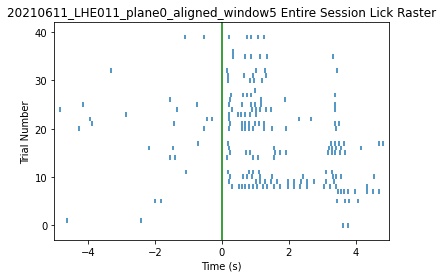

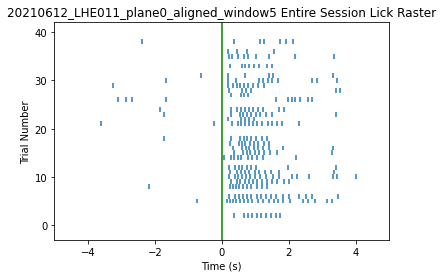

In [409]:
def gen_session_lick_raster(aligned_list):
    
    counter = 0
    for aligned_file in aligned_list:
        
        # use converters with eval function to retain list from csv format
        session_df = pd.read_csv(aligned_file, converters={"LiquidOn_licks": eval}, index_col="trial")
        
        session_df["centered_licks"] = np.empty((len(session_df), 0)).tolist()
        
        
        for lick_list in session_df["LiquidOn_licks"].items():
            for lick in lick_list[1]:
                value = (lick - session_df["LiquidOn"].loc[lick_list[0]]).round(3)
                session_df["centered_licks"].loc[lick_list[0]].append(value)

        session_liquid_centered_lists = [lick for lick in session_df["centered_licks"]]
        
        session_lick_raster_fig, ax = plt.subplots()
        plt.xlim(-5, 5)
        plt.title(aligned_file.stem + " Entire Session Lick Raster")
        plt.xlabel("Time (s)")
        plt.ylabel("Trial Number")
        plt.axvline(x=0, ymin=0, ymax=40, color="green", label="test")
        ax.eventplot(positions=session_liquid_centered_lists)
        
        counter += 1
        
        if counter == 7:
            break

gen_session_lick_raster(aligned_list)

# BELOW THIS POINT IS DEPRECATED/ONLY FOR PICKING APART SCRAPS 

In [698]:
# TODO: This needs to be done by writing things to HDF5/Zarr in NWB format so a complete dataset for a given session is available for analysis
def merge_2p_behavior(cleaned_behavior_dict, config_trial_types):
    """
    Merges one twop behavior, configuration, video, and microscopy files' data together.
    
    Parameters
    ----------
    arg1: dict
        Dictionary of cleaned behavior data timestamps
    arg2: list
        List of trialtypes from configuration file
    
    Returns
    -------
    1. list
        List of merged 2P behavior paths
    """

    # TODO: Use Kyle's code to align these files with the relative timestamps of microscopy
    # TODO: Get zipping of these two lists to work so finding config file is already completed...
    # TODO: Make force overwrite/recompile the different datasets
    # TODO: Make verbose version of this function
    needs_merging = []
    
    merged_list = []
    
    # Give name_date pattern for the files we're aligning
    name_date_pattern = re.compile("\d{8}_[A-Z]{3}\d{3}")
    
    # First, check for cleaned data
    for directory in twop_raw_beh_list:
        
        # Glob for the aligned json file
        cleaned_check = directory.parents[1].glob("*_merged.json")
        
        # Make a list using the result of the glob using list comprehension
        clean_checklist = [session for session in cleaned_check]
        
        # If the list is empty, the session needs merging
        if len(clean_checklist) == 0:
            
            # Show which session needs alignment and append the directory to needs_merging list
            print("Session Needs Merging:", directory.parents[3].name, directory.parents[1].name)
            needs_merging.append(directory)
        
        # Else, the session has already been merged.  Append the filepath to the merged_list.
        else:
            merged_file = clean_checklist[0]
            print("Session already merged:", merged_file)
            merged_list.append(merged_file)
    
    # Now, do the merging
    for raw_file in needs_merging:
        print("Merging:", raw_file.name)
        
        merged = {}
        
        parent_folder = raw_file.parents[1]
        
        # From Kyle Fischer, June 2021 thru line 92
        raw_behavior_df = pd.read_csv(raw_file, index_col="Time(ms)").rename(columns=lambda col:col.strip())
        
        # Any value below 3V is not signal, turn it to zero by filtering
        # values so all that remains are values greater than 3. All else
        # will be 0.
        raw_behavior_df = raw_behavior_df > 3
        
        # Convert all values to int; is necessary for pd.df.diff() to produce
        # negative values used for stop times of each event
        raw_behavior_df = raw_behavior_df.astype(int)
        
        # Take the diff of each column; gives start and stop of each signal
        raw_behavior_df = raw_behavior_df.diff()

        # Replace any NaN values with 0
        raw_behavior_df = raw_behavior_df.fillna(0)
        
        # Grab start and stop values for licks
        merged["LickOn"] = raw_behavior_df[raw_behavior_df["Lick"] == 1].index.tolist()
        merged["LickOff"] = raw_behavior_df[raw_behavior_df["Lick"] == -1].index.tolist()
        
        # Grab start and stop values for Airpuff Solenoid
        merged["AirpuffOn"] = raw_behavior_df[raw_behavior_df["Airpuff"] == 1].index.tolist()
        merged["AirpuffOff"] = raw_behavior_df[raw_behavior_df["Airpuff"] == -1].index.tolist()
        
        # Grab start and stop values for Liquid Solenoid
        merged["LiquidOn"] = raw_behavior_df[raw_behavior_df["Liquid"] == 1].index.tolist()
        merged["LiquidOff"] = raw_behavior_df[raw_behavior_df["Liquid"] == -1].index.tolist()
        
        # Grab start and stop values for Speaker
        merged["SpeakerOn"] = raw_behavior_df[raw_behavior_df["Speaker"] == 1].index.tolist()
        merged["SpeakerOff"] = raw_behavior_df[raw_behavior_df["Speaker"] == -1].index.tolist()
        
        
        #TODO: This should be just one regex, not sure why complete isn't working...
        
        # Perform the regex for the name and date of the file
        r_name_date = re.search(pattern=name_date_pattern, string=raw_file.name)
        
        # Give the pattern for the plane of interest
        plane_pattern = "_plane\d{1}"
        
        # Perform the regex for the plane number of the file
        r_plane = re.search(pattern=plane_pattern, string=raw_file.name)
        
        # Concatenate strings into final merged file as json type
        merged_name = r_name_date.group(0) + r_plane.group(0) + "_merged.json"
        
        # Append the parent folder with this name to create the file later
        merged_filename = parent_folder / merged_name
        
        # Grab the config file for this plane from the parent folder
        config_glob = parent_folder.glob("*.json")
        
        # Config gather the config file result in a list
        config_file_result = [config for config in config_glob]
        
        # The config file is the only element of this list, not sure how to retain only the relevant file without lists...
        config_file = config_file_result[0]
        
        # Open the json file using json package
        with open(config_file, "r") as inFile:
            
            # The configuration is the read file
            config = inFile.read()
            
            # Load the contents of the config with json.loads()
            config_contents = json.loads(config)
            
            # Gather the trial types from the configuration
            trial_types = config_contents["trialArray"]
        
        # Append trial types to merged file
        merged_df["trialTypes"] = trial_types

        # Create the new file using json package
        with open(merged_filename, "w") as outFile:
            
            # Use json.dump to write aligned_dictionary to file
            json.dump(merged, outFile)
        
        # Tell user the file has been written
        print("Written", merged_filename)
        aligned_list.append(merged_filename)
        
    return merged_list

merged_list = merge_2p_behavior(twop_raw_beh_list, twop_config_list)

Session Needs Merging: LHE011 20210603
Session Needs Merging: LHE011 20210604
Session Needs Merging: LHE011 20210605
Session Needs Merging: LHE011 20210607
Session Needs Merging: LHE011 20210608
Session Needs Merging: LHE011 20210611
Session Needs Merging: LHE011 20210612
Merging: 20210603_LHE011_plane0-042_Cycle00001_VoltageRecording_001.csv


NameError: name 'merged_df' is not defined

In [318]:
# TODO: This alignment function should be used to align lick rasters specifically, these alignment positions should not be written out to disk
# However, I will be keeping it as a means of hosting static datasets for use on a sideproject that will display static datasets online for the lab...


# TODO: Write the merged datafile using some of this code, eventually should be incorporated into raster plot generation/psth/lick probability functions
# TODO: Get this to incorporate the training data from the headfix boxes
# TODO: Should not rely upon aligned file
def align_2p_behavior(merged_list, alignment_positions=["LiquidOn", "SpeakerOn", "AirpuffOn"], prewindow=5, postwindow=5):
    """
    Aligns twop behavior to different positions from user within specific windows
    
    Parameters
    ----------
    arg1: list
        List of paths for merged behavior data
    arg2: list
        Alignment positions to store
    arg3: int
        Window (in seconds) for pre/post event alignment
    
    Returns
    -------
    1. list
        List of aligned 2P behavior paths
    """

    needs_alignment = []
    
    aligned_list = []
    
    # First, check for cleaned data
    for directory in merged_list:
        
        clean_name_pattern = "*aligned_window" + str(window) + "*"
        
        # Glob for the aligned json file
        cleaned_check = directory.parents[0].glob(clean_name_pattern)
        
        # Make a list using the result of the glob using list comprehension
        clean_checklist = [session for session in cleaned_check]
        
        # If the list is empty, the session needs alignment
        if len(clean_checklist) == 0:
            
            # Show which session needs alignment and append the directory to needs_merging list
            print("Session Needs Alignment:", directory.parents[2].name, directory.parents[0].name)
            needs_alignment.append(directory)
        
        # Else, the session has already been aligned.  Append the filepath to the aligned_list.
        else:
            aligned_file = clean_checklist[0]
            print("Session already aligned:", aligned_file)
            aligned_list.append(aligned_file)

    for merged_file in needs_alignment:

        with open(merged_file, "r") as inFile:

            contents = inFile.read()

            timestamps = json.loads(contents)

        trial_df = pd.DataFrame()
        
        lick_timestamps = []
        liquid_counter = 0
        airpuff_counter = 0

        # TODO: Each segment should be its own function call ie liquidon, speakers, airpuffon
        for (index, trial) in enumerate(timestamps["trialTypes"]):
            if trial == 1:
                liquid_counter += 1
                trial_name = "Trial_" + str(index + 1)
                trial_type = "Sucrose_" + str(liquid_counter)
                s = pd.Series(trial_type, dtype=str, name=trial_name)
                trial_df = trial_df.append(s)
            else:
                airpuff_counter += 1
                trial_name = "Trial_" + str(index + 1)
                trial_type = "Airpuff_" + str(airpuff_counter)
                s = pd.Series(trial_type, dtype=str, name=trial_name)
                trial_df = trial_df.append(s)
        
        trial_df.index.name = "trial"
        trial_df.columns = ["trial_type"]
        
        exclude_keys = ["LickOn", "LickOff", "LiquidOff", "AirpuffOff", "trialTypes"]
        
        for key in timestamps.keys():
            if key not in exclude_keys:
                trial_df[key] = np.nan
        
        speakeron_df = pd.DataFrame()
        
        for (index, trial) in enumerate(timestamps["SpeakerOn"]):
            trial_number = "Trial_" + str(index + 1)
            speaker_on_ms = trial
            s = pd.Series(speaker_on_ms, name=trial_number)
            speakeron_df = speakeron_df.append(s)
        
        speakeron_df.index.name = "trial"
        speakeron_df.columns = ["SpeakerOn"]
        
        trial_df.update(speakeron_df)
        
        trial_df["SpeakerOn"] = trial_df["SpeakerOn"].divide(1000)
        
        speakeroff_df = pd.DataFrame()
        
        for (index, trial) in enumerate(timestamps["SpeakerOff"]):
            
            trial_number = "Trial_" + str(index + 1)
            speaker_off_ms = trial
            s = pd.Series(speaker_off_ms, dtype=int, name=trial_number)
            speakeroff_df = speakeroff_df.append(s)
        
        speakeroff_df.index.name = "trial"
        speakeroff_df.columns = ["SpeakerOff"]
        
        trial_df.update(speakeroff_df)
        
        trial_df["SpeakerOff"] = trial_df["SpeakerOff"].divide(1000)
        
        trial_df.reset_index(inplace=True)
        trial_df.set_index("trial_type", inplace=True)

        
        liquid_df = pd.DataFrame()

        for (index, trial) in enumerate(timestamps["LiquidOn"]):
            
            liquid_trial = "Sucrose_" + str(index + 1)
            liquid_start_ms = trial
            s = pd.Series(liquid_start_ms, dtype=int, name=liquid_trial)
            liquid_df = liquid_df.append(s)
        
        liquid_df.index.name = "trial_type"
        liquid_df.columns = ["LiquidOn"]
        
        trial_df.update(liquid_df)
        
        trial_df["LiquidOn"] = trial_df["LiquidOn"].divide(1000)
        
        airpuff_df = pd.DataFrame()

        for (index, trial) in enumerate(timestamps["AirpuffOn"]):
            airpuff_trial = "Airpuff_" + str(index + 1)
            airpuff_start_ms = trial
            s = pd.Series(airpuff_start_ms, dtype=int, name=airpuff_trial)
            airpuff_df = airpuff_df.append(s)
        
        airpuff_df.index.name = "trial_type"
        
        if airpuff_df.size > 0:
            airpuff_df.columns = ["AirpuffOn"]
            trial_df.update(airpuff_df)
        else:
            pass
        
        trial_df.reset_index(inplace=True)
        trial_df.set_index("trial", inplace=True)
        
        trial_df["AirpuffOn"] = trial_df["AirpuffOn"].divide(1000)
        
        # Use list comprehension for lick timestamps
        lick_timestamps = [lick for (index, lick) in enumerate(timestamps["LickOn"])]
        
        lick_timestamps = [lick/1000 for lick in lick_timestamps]
        
        # Create columns for aligning licks to different events and then create lick lists
        # This is terrible and a better way to assign licks to a list should be found, but
        # without using a relational system I'm not sure how I can alter this...
        # TODO: Make this a function that is iterated over instead of multiple for loops like this...
        # Possible solutions: Create ITI starts/stops as dataframe values and evaluate against range
        
        for target in alignment_positions:
            column = target + "_licks"
            trial_df[column] = np.empty((len(trial_df), 0)).tolist()
            for lick_time in lick_timestamps:
                for value in trial_df[target].items():
                    if (value[1] - prewindow) <= lick_time <= (value[1] + postwindow):
                        tmp = value[0]
                        trial_df[column].loc[tmp].append(lick_time)
                    else:
                        pass

        # Create empty lists for ITI licks
        trial_df["ITI_licks"] = np.empty((len(trial_df), 0)).tolist()

        # Get leftover ITI licks by creating sets out of aligned licks
        accounted_licks = []
        for value in trial_df["LiquidOn_licks"].items():
            if len(value[1]) == 0:
                pass
            else:
                for licks in value[1]:
                    accounted_licks.append(licks)
        
        accounted_licks = set(accounted_licks)
        licks_set = set(lick_timestamps) 
        iti_licks = list(licks_set - accounted_licks)


        # Again, a bad way to do this. Too many loops and likely to be quite slow...
        for lick_time in iti_licks:
            for value in trial_df["ITI_licks"].items():
                tmp = value[0]
                if (trial_df["SpeakerOn"].loc[tmp] - prewindow) <= lick_time <= (trial_df["LiquidOn"].loc[tmp] + postwindow):
                    trial_df["ITI_licks"].loc[tmp].append(lick_time)

        aligned_filename = merged_file.stem
        aligned_filename = aligned_filename.replace("merged", "aligned")
        aligned_filename = aligned_filename + "_" + "window" + str(window) + ".csv"
        
        aligned_file_path = merged_file.parents[0] / aligned_filename
        
        aligned_list.append(aligned_file_path)
        
        trial_df.to_csv(aligned_file_path)

    return aligned_list


aligned_list = align_2p_behavior(merged_list)

Session Needs Alignment: LHE011 20210603
Session Needs Alignment: LHE011 20210604
Session Needs Alignment: LHE011 20210605
Session Needs Alignment: LHE011 20210607
Session Needs Alignment: LHE011 20210608
Session Needs Alignment: LHE011 20210611
Session Needs Alignment: LHE011 20210612
Session Needs Alignment: LHE012 20210603
Session Needs Alignment: LHE012 20210604
Session Needs Alignment: LHE012 20210605
Session Needs Alignment: LHE012 20210606
Session Needs Alignment: LHE012 20210607
Session Needs Alignment: LHE012 20210610
Session Needs Alignment: LHE012 20210611
Session Needs Alignment: LHE013 20210603
Session Needs Alignment: LHE013 20210604
Session Needs Alignment: LHE013 20210605
Session Needs Alignment: LHE013 20210606
Session Needs Alignment: LHE013 20210610
Session Needs Alignment: LHE014 20210603
Session Needs Alignment: LHE014 20210604
Session Needs Alignment: LHE014 20210605
Session Needs Alignment: LHE014 20210606
Session Needs Alignment: LHE014 20210609
Session Needs Al